In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from rake_nltk import Rake

In [2]:
path='/storage/personal_data/emotions_dataset/train.txt'

In [3]:
df = pd.read_csv(path, sep=';', header=None)

In [4]:
df.head()

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df.rename(columns={0: "statments", 1: "emotion"}, inplace=True)

In [6]:
df.emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [7]:
df = df[df['emotion'].isin(['joy', 'sadness'])]

In [8]:
df.head()

,statments,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
5,ive been feeling a little burdened lately wasn...,sadness
8,i have been with petronas for years i feel tha...,joy
10,i feel like i have to make the suffering i m s...,sadness


In [9]:
def change_response(data):
    if data == 'joy':
        return 1
    elif (data == "sadness"):
        return 0

In [10]:
df['emotion'] = df['emotion'].apply(lambda x: change_response(x))

In [11]:
df_changed_int = df

In [12]:
df_changed_int.head()

,statments,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
5,ive been feeling a little burdened lately wasn...,0
8,i have been with petronas for years i feel tha...,1
10,i feel like i have to make the suffering i m s...,0


In [13]:
df_changed_int.statments[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [14]:
df_changed_int.isna().sum()

statments    0
emotion      0
dtype: int64

In [15]:
r = Rake()

In [16]:
myText = 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [17]:
r.extract_keywords_from_text(myText)

In [18]:
r.get_ranked_phrases()

['damned hopeful',
 'around someone',
 'hopeless',
 'go',
 'feeling',
 'cares',
 'awake']

In [19]:
r.get_ranked_phrases_with_scores()

[(4.0, 'damned hopeful'),
 (4.0, 'around someone'),
 (1.0, 'hopeless'),
 (1.0, 'go'),
 (1.0, 'feeling'),
 (1.0, 'cares'),
 (1.0, 'awake')]

In [20]:
### Training and modelling time

In [21]:
X_train,X_test,y_train,y_test=train_test_split(df_changed_int['statments'],df_changed_int['emotion'].values,test_size=0.20)

In [22]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [23]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=padding_type)

validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(y_train)
validation_labels_final = np.array(y_test)

In [24]:
X_train

14613    i feel that would be a far more considerate an...
13662                i feel so fucking stupid for doing so
12231    i read them it is the only point of my day whe...
8291     im sharing our school room because im sure im ...
4185                               i feel pretty fantastic
                               ...                        
7932     i feel deeply humiliated when i read in ari be...
11813    i feel like weve been doomed from the start an...
1936     i feel i would be ungrateful to god and unduti...
3643         i do feel alittle submissive it isnt the same
8458     i looked down at my sweet boy hudson i knew th...
Name: statments, Length: 8022, dtype: object

In [25]:
training_sequences[0]

[2, 3, 8, 63, 27, 7, 379, 35, 1, 4, 1, 1, 28, 6, 240, 10, 1]

In [26]:
from keras.regularizers import l2

In [27]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Conv1D(16, 5, activation='relu'),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Dropout(0.65),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# lr = 0.00005
# model.compile(loss='binary_crossentropy',
#               optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
#               metrics=['accuracy'])
# model.summary()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr = 0.001
model.compile(loss='binary_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 9,313
Trainable params: 9,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# %%time
# num_epochs = 70
# history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
#                     validation_data=(validation_padded, validation_labels_final))

In [30]:
%%time
num_epochs = 10
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
251/251 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.5795 - val_loss: 0.6468 - val_accuracy: 0.7488
Epoch 2/10
251/251 [==============================] - 1s 2ms/step - loss: 0.4872 - accuracy: 0.8209 - val_loss: 0.3868 - val_accuracy: 0.8220
Epoch 3/10
251/251 [==============================] - 1s 2ms/step - loss: 0.3109 - accuracy: 0.8711 - val_loss: 0.3202 - val_accuracy: 0.8410
Epoch 4/10
251/251 [==============================] - 1s 2ms/step - loss: 0.2646 - accuracy: 0.8858 - val_loss: 0.3081 - val_accuracy: 0.8470
Epoch 5/10
251/251 [==============================] - 1s 2ms/step - loss: 0.2449 - accuracy: 0.8929 - val_loss: 0.3128 - val_accuracy: 0.8425
Epoch 6/10
251/251 [==============================] - 1s 2ms/step - loss: 0.2351 - accuracy: 0.8953 - val_loss: 0.3169 - val_accuracy: 0.8405
Epoch 7/10
251/251 [==============================] - 1s 2ms/step - loss: 0.2365 - accuracy: 0.8953 - val_loss: 0.3207 - val_accuracy: 0.8395
Epoch 

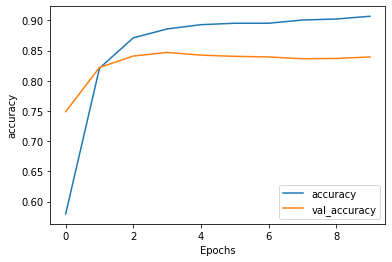

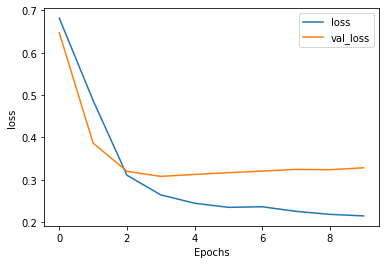

In [31]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
def predict_sentiment(model, reviews):
    
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length) 
    
    classes = model.predict(fakes_padded)

    # The closer the class is to 1, the more positive the review is deemed to be
    for x in range(len(reviews)):
      print(reviews[x])
      print(classes[x])
      print('\n')

In [33]:
predict_sentiment(model, ['I have been feeling very bad',
                          "I have been feeling very happy today",
                         "I think the world is ending",
                         "Sometimes I sleep alone",
                         "I think I don't have any friends",
                         "I just feel so exhausted, I don't know what to do",
                         "It's been such a long day and I honestly feel like there's still so much to do!",
                         "Everything is making me feel terrible I don't know how I can go like this anymore",
                         "I'm so alone and I think everyone else would be better off without me",
                         "This was the best day ever!",
                         "I don't feel like getting out of bed or even having fun, nothing is the same anymore"])

I have been feeling very bad
[0.0153566]


I have been feeling very happy today
[0.96988297]


I think the world is ending
[0.6377342]


Sometimes I sleep alone
[0.00836894]


I think I don't have any friends
[0.6377342]


I just feel so exhausted, I don't know what to do
[2.402112e-06]


It's been such a long day and I honestly feel like there's still so much to do!
[0.67873055]


Everything is making me feel terrible I don't know how I can go like this anymore
[0.00395685]


I'm so alone and I think everyone else would be better off without me
[0.10046801]


This was the best day ever!
[0.65948385]


I don't feel like getting out of bed or even having fun, nothing is the same anymore
[0.64830554]




In [ ]:
isEnd = False

while True:
    val = input('How are you feeling today: ')
    
    if val == 'end':
        break
        
    predict_sentiment(model, [val])

In [34]:
# model.save('emotions.h5')

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
predictions = model.predict_classes(validation_padded)
print(classification_report(validation_labels_final, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       926
           1       0.80      0.93      0.86      1080

    accuracy                           0.84      2006
   macro avg       0.85      0.83      0.84      2006
weighted avg       0.85      0.84      0.84      2006

